<a href="https://colab.research.google.com/github/Nkanga-Pedro/ExplorandoDados/blob/main/ClusterAnonimazado2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
from plotnine import *
import plotnine
# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Import module for normalization scale Max-Min
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# importando a base de dados - microdados_enade_2019
dados = pd.read_csv('ds2-anonymized.csv',sep=",", encoding="utf-8")
dados.head(5)

C:\Users\Metusalém Feliciano\AppData\Local\Temp\ipykernel_2124\51711578.py:2: DtypeWarning: Columns (2,3,14,15) have mixed types. Specify dtype option on import or set low_memory=False.


,uni_id,prog_id,reg,age,gen,gpa1,gpa2,race,edu_f,edu_m,inco,work,schol,ac_schol,years2finish,years_leave
0,3849,17147,1,21,F,62,59,A,5,5,5,A,A,D,4,1
1,383,18309,1,21,F,68,76,A,5,5,5,A,A,A,4,1
2,549,21846,1,21,F,49,41,A,6,4,4,A,A,B,4,1
3,750,50884,1,21,F,59,50,A,3,4,6,A,A,A,4,1
4,2469,56334,1,21,F,27,26,A,4,5,1,A,A,A,4,1


In [ ]:
dados=dados.applymap(lambda x: x if '*' not in str(x) else None).dropna()

In [ ]:
# The dimension of data
print('Dimension data: {} rows and {} columns'.format(len(dados), len(dados.columns)))

Dimension data: 127032 rows and 16 columns


In [ ]:
# Check missing value
dados.isna().sum()

uni_id          0
prog_id         0
reg             0
age             0
gen             0
gpa1            0
gpa2            0
race            0
edu_f           0
edu_m           0
inco            0
work            0
schol           0
ac_schol        0
years2finish    0
years_leave     0
dtype: int64

In [ ]:
# Selecione somente as colunas numéricas
num_cols = ['age', 'gpa1', 'gpa2', 'edu_f', 'edu_m', 'inco', 'years2finish', 'years_leave']
dados_num = dados[num_cols]

# Instancie o objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplique a normalização min-max às colunas numéricas
dados_norm = scaler.fit_transform(dados_num)
dados_norm = pd.DataFrame(dados_norm, columns=num_cols)

# Junte as colunas normalizadas com as colunas não numéricas
dados_norm = pd.concat([dados_norm, dados.drop(num_cols, axis=1)], axis=1)

In [ ]:
dados_norm.head()

,age,gpa1,gpa2,edu_f,edu_m,inco,years2finish,years_leave,uni_id,prog_id,reg,gen,race,work,schol,ac_schol
0,0.053,0.674,0.602,0.800,0.800,0.667,0.143,0.059,3849,17147,1,F,A,A,A,D
1,0.053,0.739,0.776,0.800,0.800,0.667,0.143,0.059,383,18309,1,F,A,A,A,A
2,0.053,0.533,0.418,1.000,0.600,0.500,0.143,0.059,549,21846,1,F,A,A,A,B
3,0.053,0.641,0.510,0.400,0.600,0.833,0.143,0.059,750,50884,1,F,A,A,A,A
4,0.053,0.293,0.265,0.600,0.800,0.000,0.143,0.059,2469,56334,1,F,A,A,A,A


In [ ]:
# Get the position of categorical columns
catColumnsPos = [dados_norm.columns.get_loc(col) for col in list(dados_norm.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(dados_norm.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['reg', 'gen', 'race', 'work', 'schol', 'ac_schol']
Categorical columns position  : [10, 11, 12, 13, 14, 15]


In [ ]:
# Convert dataframe to matrix
#X = dados_norm.to_numpy()
# Convertendo as colunas categóricas em variáveis codificadas
data = pd.get_dummies(dados_norm, columns=['gen', 'race', 'work', 'schol', 'ac_schol'])

# Separando as features (X) da variável alvo (y)
X = data.drop(["uni_id", "prog_id"], axis=1).values

In [ ]:
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
scores = []
for k in range(2, 13):
    km = KPrototypes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    labels = km.fit_predict(X, categorical=[11, 12, 13, 14, 15])

    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    db_score = davies_bouldin_score(X, labels)

    scores.append((k, silhouette, ch_score, db_score))

In [ ]:
scores = pd.DataFrame(scores, columns=["k", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
print(scores)

     k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0    2       0.171          23327.724           2.205
1    3       0.176          24496.475           1.916
2    4       0.156          19060.585           1.966
3    5       0.165          17237.495           2.010
4    6       0.156          16411.301           2.104
5    7       0.154          15998.615           1.982
6    8       0.119          13553.640           1.939
7    9       0.158          12890.719           2.090
8   10       0.155          12618.755           2.311
9   11       0.175          12127.838           2.055
10  12       0.161          11271.102           2.040


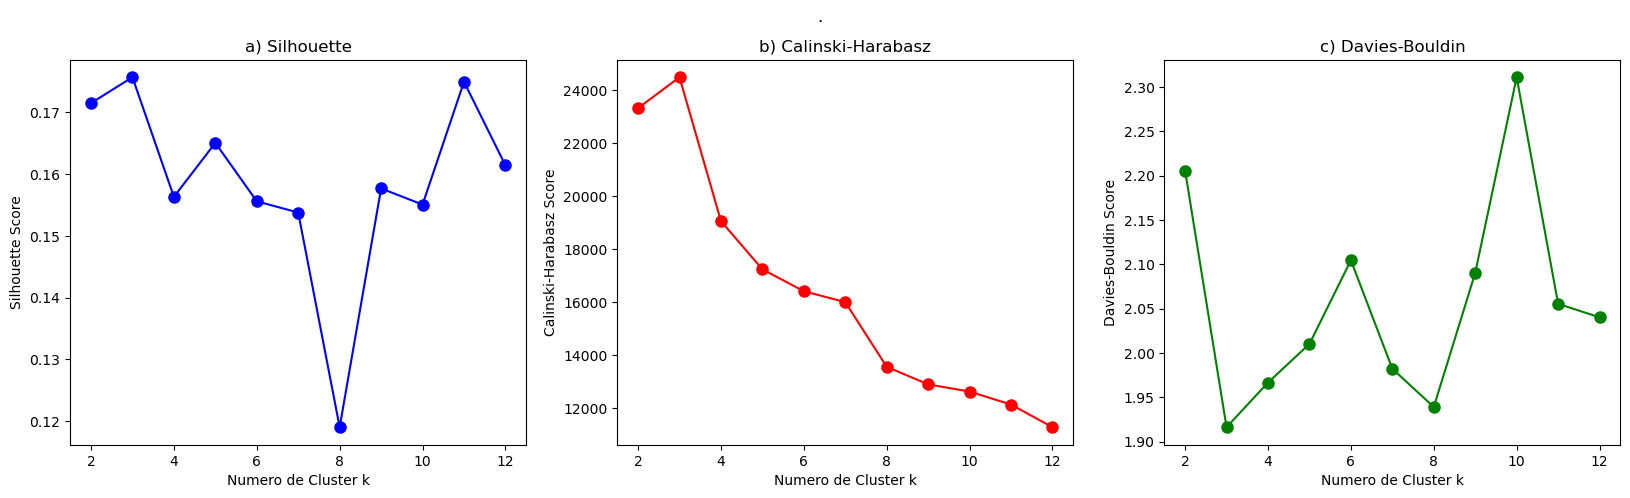

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('.')

# Gráfico de linha para a medida Silhouette
ax1.plot(scores['k'], scores['Silhouette'], 'bo-', markersize=8)
ax1.set_title('a) Silhouette')
ax1.set_xlabel('Numero de Cluster k')
ax1.set_ylabel('Silhouette Score')

# Gráfico de linha para a medida Calinski-Harabasz
ax2.plot(scores['k'], scores['Calinski-Harabasz'], 'ro-', markersize=8)
ax2.set_title('b) Calinski-Harabasz')
ax2.set_xlabel('Numero de Cluster k')
ax2.set_ylabel('Calinski-Harabasz Score')

# Gráfico de linha para a medida Davies-Bouldin
ax3.plot(scores['k'], scores['Davies-Bouldin'], 'go-', markersize=8)
ax3.set_title('c) Davies-Bouldin')
ax3.set_xlabel('Numero de Cluster k')
ax3.set_ylabel('Davies-Bouldin Score')

plt.show()

In [ ]:
scores_k2 = scores.loc[scores['k'] == 2]
scores_k2

,k,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2,0.171,23327.724,2.205


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 30452, ncost: 296412.297258151
Run: 1, iteration: 2/100, moves: 2145, ncost: 296069.6166090539
Run: 1, iteration: 3/100, moves: 0, ncost: 296069.6166090539
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3070, ncost: 301037.56597431237
Run: 2, iteration: 2/100, moves: 8, ncost: 301037.55833816144
Run: 2, iteration: 3/100, moves: 0, ncost: 301037.55833816144
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 17435, ncost: 302006.72463058186
Run: 3, iteration: 2/100, moves: 6943, ncost: 298463.7202411622
Run: 3, iteration: 3/100, moves: 7, ncost: 298463.71251523134
Run: 3, iteration: 4/100, moves: 0, ncost: 298463.71251523134
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 18176, ncost: 3

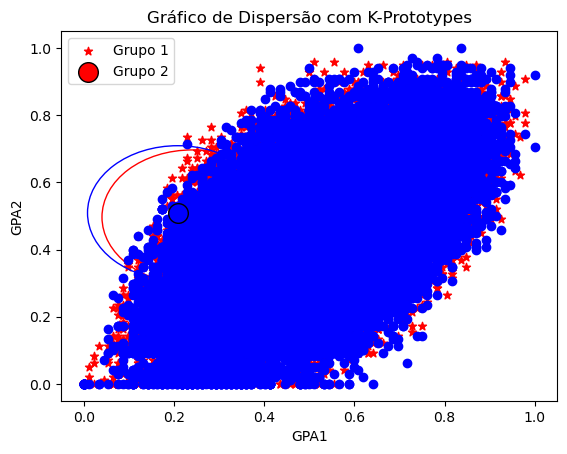

In [ ]:
# Selecionando as colunas categóricas
categorical_columns = [11, 12, 13, 14, 15]

# Instanciando o objeto KPrototypes com 5 clusters
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=2)

# Realizando a clusterização
clusters = kproto.fit_predict(X, categorical=categorical_columns)

# Adicionando a coluna com os clusters no dataframe
dados_norm['cluster'] = clusters

# Definindo as cores e símbolos para cada cluster
colors = ['r', 'b']
markers = ['*', 'o']

# Plotando o gráfico de dispersão para cada cluster
for i in range(2):
    plt.scatter(dados_norm.loc[dados_norm['cluster'] == i, 'gpa1'], dados_norm.loc[dados_norm['cluster'] == i, 'gpa2'],
                color=colors[i], marker=markers[i])

    # Adicionando um círculo em torno do centróide de cada cluster
    centroid = kproto.cluster_centroids_[i]
    plt.scatter(centroid[0], centroid[1], s=200, c=colors[i], marker='o', edgecolors='k')
    circle = plt.Circle((centroid[0], centroid[1]), radius=0.2, color=colors[i], fill=False)
    plt.gca().add_patch(circle)

# Configurando o título e legendas do gráfico
plt.title('Gráfico de Dispersão com K-Prototypes')
plt.xlabel('GPA1')
plt.ylabel('GPA2')
plt.legend(['Grupo 1', 'Grupo 2'])
plt.show()

In [ ]:
# Dados que pertencem ao cluster 1
print("Cluster 1:")
dados_norm.loc[dados_norm['cluster']==0].describe()

Cluster 1:


,age,gpa1,gpa2,edu_f,edu_m,inco,years2finish,years_leave,uni_id,prog_id,cluster
count,51951.000,51951.000,51951.000,51951.000,51951.000,51951.000,51951.000,51951.000,51951.000,51951.000,51951.000
mean,0.240,0.496,0.431,0.573,0.638,0.405,0.343,0.139,1440.815,527786.525,0.000
std,0.126,0.160,0.163,0.246,0.237,0.281,0.144,0.132,2614.386,835269.101,0.000
min,0.053,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000
25%,0.158,0.380,0.306,0.400,0.600,0.167,0.286,0.059,322.000,19779.000,0.000
50%,0.211,0.500,0.429,0.600,0.600,0.333,0.286,0.059,584.000,101506.000,0.000
75%,0.316,0.620,0.551,0.800,0.800,0.667,0.429,0.176,1494.000,1138922.000,0.000
max,1.000,0.978,0.959,1.000,1.000,1.000,1.000,1.000,23410.000,5001283.000,0.000


In [ ]:
# Dados que pertencem ao cluster 1
print("Cluster 2:")
dados_norm.loc[dados_norm['cluster']==1].describe()

Cluster 2:


,age,gpa1,gpa2,edu_f,edu_m,inco,years2finish,years_leave,uni_id,prog_id,cluster
count,75081.000,75081.000,75081.000,75081.000,75081.000,75081.000,75081.000,75081.000,75081.000,75081.000,75081.000
mean,0.208,0.509,0.428,0.542,0.617,0.335,0.293,0.128,1460.324,458951.630,1.000
std,0.112,0.153,0.164,0.246,0.241,0.267,0.129,0.113,2555.938,844992.113,0.000
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,3.000,1.000
25%,0.158,0.391,0.306,0.400,0.400,0.167,0.143,0.059,322.000,19584.000,1.000
50%,0.211,0.511,0.429,0.600,0.600,0.333,0.286,0.059,582.000,86288.000,1.000
75%,0.263,0.620,0.541,0.800,0.800,0.500,0.429,0.176,1563.000,1106043.000,1.000
max,0.947,1.000,1.000,1.000,1.000,1.000,0.857,1.000,23410.000,5001378.000,1.000


In [ ]:
scores_k5 = scores.loc[scores['k'] == 5]
scores_k5

,k,Silhouette,Calinski-Harabasz,Davies-Bouldin
3,5,0.165,17237.495,2.010


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 39607, ncost: 222516.89972397924
Run: 1, iteration: 2/100, moves: 6973, ncost: 220295.29077891118
Run: 1, iteration: 3/100, moves: 4170, ncost: 219467.66338833305
Run: 1, iteration: 4/100, moves: 447, ncost: 219454.22385013514
Run: 1, iteration: 5/100, moves: 400, ncost: 219426.29039633536
Run: 1, iteration: 6/100, moves: 931, ncost: 219308.6021108229
Run: 1, iteration: 7/100, moves: 851, ncost: 219178.54337077658
Run: 1, iteration: 8/100, moves: 86, ncost: 219177.5703825651
Run: 1, iteration: 9/100, moves: 60, ncost: 219176.97341876518
Run: 1, iteration: 10/100, moves: 53, ncost: 219176.65153853086
Run: 1, iteration: 11/100, moves: 36, ncost: 219176.49779278174
Run: 1, iteration: 12/100, moves: 17, ncost: 219176.4416257113
Run: 1, iteration: 13/100, moves: 22, ncost: 219176.38169857571
Run: 1, iteration: 14/100, moves: 18, ncost: 219176.34828947214
Run: 1, iteration: 15/100

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


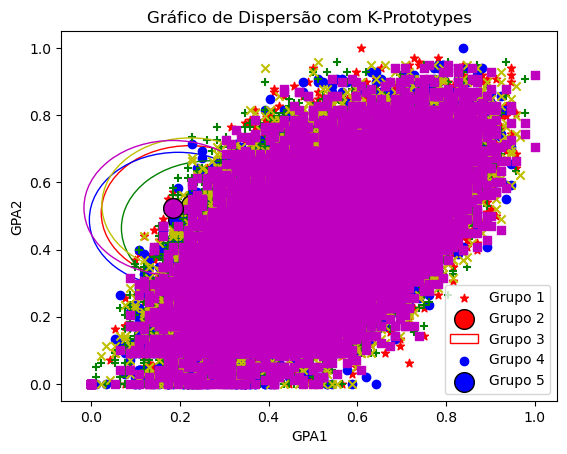

In [ ]:
# Selecionando as colunas categóricas
categorical_columns = [11, 12, 13, 14, 15]

# Instanciando o objeto KPrototypes com 5 clusters
kproto = KPrototypes(n_clusters=5, init='Huang', verbose=2)

# Realizando a clusterização
clusters = kproto.fit_predict(X, categorical=categorical_columns)

# Adicionando a coluna com os clusters no dataframe
dados_norm['cluster'] = clusters

# Definindo as cores e símbolos para cada cluster
colors = ['r', 'b', 'g', 'y', 'm']
markers = ['*', 'o', '+', 'x', 's']

# Plotando o gráfico de dispersão para cada cluster
for i in range(5):
    plt.scatter(dados_norm.loc[dados_norm['cluster'] == i, 'gpa1'], dados_norm.loc[dados_norm['cluster'] == i, 'gpa2'],
                color=colors[i], marker=markers[i])

    # Adicionando um círculo em torno do centróide de cada cluster
    centroid = kproto.cluster_centroids_[i]
    plt.scatter(centroid[0], centroid[1], s=200, c=colors[i], marker='o', edgecolors='k')
    circle = plt.Circle((centroid[0], centroid[1]), radius=0.2, color=colors[i], fill=False)
    plt.gca().add_patch(circle)

# Configurando o título e legendas do gráfico
plt.title('Gráfico de Dispersão com K-Prototypes')
plt.xlabel('GPA1')
plt.ylabel('GPA2')
plt.legend(['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4', 'Grupo 5'])
plt.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 50027, ncost: 178940.63747076763
Run: 1, iteration: 2/100, moves: 10029, ncost: 175151.38863232627
Run: 1, iteration: 3/100, moves: 1292, ncost: 174987.9486640775
Run: 1, iteration: 4/100, moves: 148, ncost: 174984.12937606455
Run: 1, iteration: 5/100, moves: 261, ncost: 174957.75329176153
Run: 1, iteration: 6/100, moves: 435, ncost: 174914.04787372815
Run: 1, iteration: 7/100, moves: 66, ncost: 174913.01907241106
Run: 1, iteration: 8/100, moves: 39, ncost: 174912.52794595208
Run: 1, iteration: 9/100, moves: 21, ncost: 174912.36373367417
Run: 1, iteration: 10/100, moves: 15, ncost: 174912.305899142
Run: 1, iteration: 11/100, moves: 6, ncost: 174912.292434592
Run: 1, iteration: 12/100, moves: 3, ncost: 174912.28927850473
Run: 1, iteration: 13/100, moves: 2, ncost: 174912.28734555628
Run: 1, iteration: 14/100, moves: 1, ncost: 174912.28588391733
Run: 1, iteration: 15/100, move

Run: 10, iteration: 5/100, moves: 426, ncost: 170003.84675725506
Run: 10, iteration: 6/100, moves: 388, ncost: 169980.0860871315
Run: 10, iteration: 7/100, moves: 355, ncost: 169958.91699785448
Run: 10, iteration: 8/100, moves: 322, ncost: 169938.7601956088
Run: 10, iteration: 9/100, moves: 240, ncost: 169926.75556574386
Run: 10, iteration: 10/100, moves: 154, ncost: 169922.29641071885
Run: 10, iteration: 11/100, moves: 93, ncost: 169920.83057232905
Run: 10, iteration: 12/100, moves: 45, ncost: 169920.42983655812
Run: 10, iteration: 13/100, moves: 36, ncost: 169920.2001386981
Run: 10, iteration: 14/100, moves: 18, ncost: 169920.14076400961
Run: 10, iteration: 15/100, moves: 3, ncost: 169920.13864762202
Run: 10, iteration: 16/100, moves: 2, ncost: 169920.1377394508
Run: 10, iteration: 17/100, moves: 0, ncost: 169920.1377394508
Best run was number 6


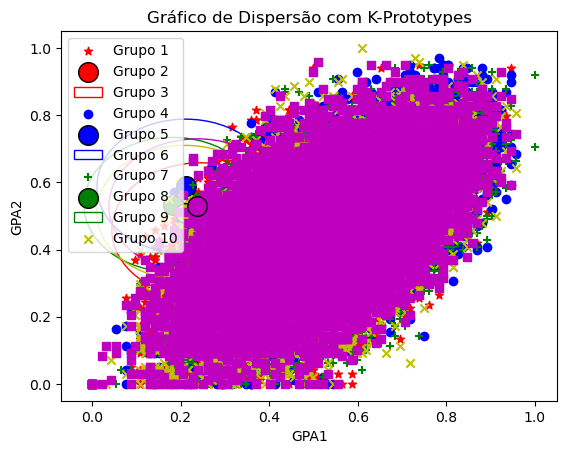

In [ ]:
# Selecionando as colunas categóricas
categorical_columns = [11, 12, 13, 14, 15]

# Instanciando o objeto KPrototypes com 10 clusters
kproto = KPrototypes(n_clusters=10, init='Huang', verbose=2)

# Realizando a clusterização
clusters = kproto.fit_predict(X, categorical=categorical_columns)

# Adicionando a coluna com os clusters no dataframe
dados_norm['cluster'] = clusters

# Definindo as cores e símbolos para cada cluster
colors = ['r', 'b', 'g', 'y', 'm']
markers = ['*', 'o', '+', 'x', 's']

# Plotando o gráfico de dispersão para cada cluster
for i in range(5):
    plt.scatter(dados_norm.loc[dados_norm['cluster'] == i, 'gpa1'], dados_norm.loc[dados_norm['cluster'] == i, 'gpa2'],
                color=colors[i], marker=markers[i])

    # Adicionando um círculo em torno do centróide de cada cluster
    centroid = kproto.cluster_centroids_[i]
    plt.scatter(centroid[0], centroid[1], s=200, c=colors[i], marker='o', edgecolors='k')
    circle = plt.Circle((centroid[0], centroid[1]), radius=0.2, color=colors[i], fill=False)
    plt.gca().add_patch(circle)

# Configurando o título e legendas do gráfico
plt.title('Gráfico de Dispersão com K-Prototypes')
plt.xlabel('GPA1')
plt.ylabel('GPA2')
plt.legend(['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4', 'Grupo 5', 'Grupo 6', 'Grupo 7', 'Grupo 8', 'Grupo 9', 'Grupo 10'])
plt.show()

In [ ]:
scores_k10 = scores.loc[scores['k'] == 10]
scores_k10

,k,Silhouette,Calinski-Harabasz,Davies-Bouldin
8,10,0.155,12618.755,2.311
